In [1]:
trial_number_ml = "007"
random_state_init = 777

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model3_binder_nonbinder


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model3_files = ['../../data_for_ml/ml_datasets_set2/model3_binders_nonbinders/data.pkl']

# Load datasets
model3_df = load_and_concatenate_datasets(model3_files)

# Preprocess datasets
X3, y3 = preprocess_data(model3_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X3, y3)

# Output shapes
print(f"Model 3 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 3 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 17:06:48,403] A new study created in memory with name: no-name-d93ee3dd-f4e9-465d-ae6c-368e0d9fa94d


[I 2024-05-01 17:07:26,402] Trial 1 finished with value: 0.7143850506404982 and parameters: {'n_estimators': 230, 'max_depth': 70, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.7143850506404982.


[I 2024-05-01 17:08:41,266] Trial 0 finished with value: 0.7172467213198022 and parameters: {'n_estimators': 722, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.7172467213198022.


[I 2024-05-01 17:08:54,295] Trial 4 finished with value: 0.733192637064578 and parameters: {'n_estimators': 330, 'max_depth': 38, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.733192637064578.


[I 2024-05-01 17:09:02,868] Trial 2 finished with value: 0.7274484706264793 and parameters: {'n_estimators': 747, 'max_depth': 58, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 4 with value: 0.733192637064578.


[I 2024-05-01 17:09:51,509] Trial 7 finished with value: 0.733191621207042 and parameters: {'n_estimators': 221, 'max_depth': 42, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.733192637064578.


[I 2024-05-01 17:10:05,741] Trial 3 pruned. 


[I 2024-05-01 17:10:21,214] Trial 5 pruned. 


[I 2024-05-01 17:11:02,619] Trial 8 pruned. 


[I 2024-05-01 17:11:11,649] Trial 11 pruned. 


[I 2024-05-01 17:11:33,576] Trial 9 finished with value: 0.7328675626530134 and parameters: {'n_estimators': 480, 'max_depth': 45, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 4 with value: 0.733192637064578.


[I 2024-05-01 17:12:02,926] Trial 12 finished with value: 0.7312746980363474 and parameters: {'n_estimators': 300, 'max_depth': 24, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.733192637064578.


[I 2024-05-01 17:12:11,396] Trial 14 pruned. 


[I 2024-05-01 17:12:21,175] Trial 13 pruned. 


[I 2024-05-01 17:12:23,822] Trial 10 finished with value: 0.7319116407115066 and parameters: {'n_estimators': 669, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.733192637064578.


[I 2024-05-01 17:12:29,470] Trial 15 pruned. 


[I 2024-05-01 17:12:31,877] Trial 16 pruned. 


[I 2024-05-01 17:12:32,772] Trial 17 pruned. 


[I 2024-05-01 17:12:33,715] Trial 6 finished with value: 0.74084356809801 and parameters: {'n_estimators': 973, 'max_depth': 89, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.74084356809801.


[I 2024-05-01 17:12:43,052] Trial 20 pruned. 


[I 2024-05-01 17:12:43,428] Trial 19 pruned. 


[I 2024-05-01 17:13:14,201] Trial 21 pruned. 


[I 2024-05-01 17:13:24,838] Trial 18 finished with value: 0.7347814382510997 and parameters: {'n_estimators': 341, 'max_depth': 80, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 6 with value: 0.74084356809801.


[I 2024-05-01 17:13:57,675] Trial 24 finished with value: 0.7370148010443015 and parameters: {'n_estimators': 222, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.74084356809801.


[I 2024-05-01 17:14:20,288] Trial 26 pruned. 


[I 2024-05-01 17:14:28,902] Trial 22 finished with value: 0.7376512357906927 and parameters: {'n_estimators': 578, 'max_depth': 85, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.74084356809801.


[I 2024-05-01 17:14:29,889] Trial 23 finished with value: 0.7344639827710561 and parameters: {'n_estimators': 582, 'max_depth': 87, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.74084356809801.


[I 2024-05-01 17:14:54,001] Trial 27 pruned. 


[I 2024-05-01 17:15:30,414] Trial 25 finished with value: 0.7370137851867653 and parameters: {'n_estimators': 620, 'max_depth': 90, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.74084356809801.


[I 2024-05-01 17:17:05,671] Trial 31 pruned. 


[I 2024-05-01 17:17:26,358] Trial 28 finished with value: 0.7411625473643575 and parameters: {'n_estimators': 843, 'max_depth': 88, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7411625473643575.


[I 2024-05-01 17:17:28,981] Trial 29 finished with value: 0.7395676510326192 and parameters: {'n_estimators': 854, 'max_depth': 57, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7411625473643575.


[I 2024-05-01 17:17:34,555] Trial 30 finished with value: 0.7366958217779539 and parameters: {'n_estimators': 836, 'max_depth': 53, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7411625473643575.


[I 2024-05-01 17:17:57,171] Trial 34 pruned. 


[I 2024-05-01 17:17:58,756] Trial 32 pruned. 


[I 2024-05-01 17:18:22,905] Trial 33 pruned. 


[I 2024-05-01 17:18:45,877] Trial 36 pruned. 


[I 2024-05-01 17:20:06,002] Trial 35 finished with value: 0.7395671431038511 and parameters: {'n_estimators': 908, 'max_depth': 74, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7411625473643575.


[I 2024-05-01 17:20:22,411] Trial 38 finished with value: 0.7382912260384604 and parameters: {'n_estimators': 761, 'max_depth': 61, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7411625473643575.


[I 2024-05-01 17:20:25,356] Trial 37 finished with value: 0.7392446083361269 and parameters: {'n_estimators': 928, 'max_depth': 100, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7411625473643575.


[I 2024-05-01 17:20:32,400] Trial 40 pruned. 


[I 2024-05-01 17:20:52,193] Trial 42 pruned. 


[I 2024-05-01 17:21:20,314] Trial 39 finished with value: 0.7395651113887788 and parameters: {'n_estimators': 940, 'max_depth': 61, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7411625473643575.


[I 2024-05-01 17:21:35,050] Trial 44 pruned. 


[I 2024-05-01 17:22:11,008] Trial 45 pruned. 


[I 2024-05-01 17:22:16,390] Trial 41 pruned. 


[I 2024-05-01 17:22:26,171] Trial 46 pruned. 


[I 2024-05-01 17:22:57,263] Trial 47 pruned. 


[I 2024-05-01 17:22:57,919] Trial 48 pruned. 


[I 2024-05-01 17:23:01,648] Trial 49 pruned. 


[I 2024-05-01 17:23:08,699] Trial 43 finished with value: 0.7392466400511992 and parameters: {'n_estimators': 908, 'max_depth': 57, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7411625473643575.


Best trial for RandomForestClassifier:
  Value: 0.7411625473643575
  Params: 
    n_estimators: 843
    max_depth: 88
    min_samples_split: 17
    min_samples_leaf: 2
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 843, 'max_depth': 88, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


[I 2024-05-01 17:23:29,043] A new study created in memory with name: no-name-606a0d23-a028-48ea-80e4-071e3fdf47a2


RandomForestClassifier accuracy: 0.7414



[I 2024-05-01 17:23:36,423] Trial 3 finished with value: 0.7261816962789138 and parameters: {'n_estimators': 102, 'max_depth': 4, 'learning_rate': 0.20108701775430307, 'min_child_weight': 3, 'subsample': 0.9813201446096752, 'colsample_bytree': 0.5779362796107287, 'gamma': 0.5626909413236464, 'reg_lambda': 0.011063734192276577, 'reg_alpha': 0.11525780563271758}. Best is trial 3 with value: 0.7261816962789138.


[I 2024-05-01 17:23:37,580] Trial 1 finished with value: 0.7188492365830615 and parameters: {'n_estimators': 183, 'max_depth': 7, 'learning_rate': 0.27101480286028007, 'min_child_weight': 6, 'subsample': 0.9969436135958509, 'colsample_bytree': 0.8651916259517911, 'gamma': 4.456547534585129, 'reg_lambda': 0.2027192824889515, 'reg_alpha': 0.09866301155205315}. Best is trial 3 with value: 0.7261816962789138.


[I 2024-05-01 17:23:38,117] Trial 2 finished with value: 0.7271401578642611 and parameters: {'n_estimators': 109, 'max_depth': 10, 'learning_rate': 0.2947572868334379, 'min_child_weight': 4, 'subsample': 0.8983509588676808, 'colsample_bytree': 0.8191525543489815, 'gamma': 0.8140748602306142, 'reg_lambda': 0.03634489922955104, 'reg_alpha': 4.347548287979578}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:23:42,466] Trial 0 finished with value: 0.7156558884182083 and parameters: {'n_estimators': 181, 'max_depth': 4, 'learning_rate': 0.02742093799922629, 'min_child_weight': 10, 'subsample': 0.5174901339692699, 'colsample_bytree': 0.8108046492232468, 'gamma': 2.8487289286588324, 'reg_lambda': 0.09239108081741475, 'reg_alpha': 0.03867460794280539}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:23:51,966] Trial 5 finished with value: 0.7182067066914537 and parameters: {'n_estimators': 119, 'max_depth': 8, 'learning_rate': 0.03437817682792852, 'min_child_weight': 7, 'subsample': 0.6411359420564924, 'colsample_bytree': 0.7461183481489992, 'gamma': 2.184258139124278, 'reg_lambda': 8.592407092661634, 'reg_alpha': 3.860472657507957}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:23:53,452] Trial 8 pruned. 


[I 2024-05-01 17:23:57,260] Trial 9 pruned. 


[I 2024-05-01 17:24:05,231] Trial 6 finished with value: 0.7156584280620486 and parameters: {'n_estimators': 516, 'max_depth': 6, 'learning_rate': 0.18362222491330085, 'min_child_weight': 1, 'subsample': 0.6819113706847915, 'colsample_bytree': 0.8666479076981877, 'gamma': 1.772189873830049, 'reg_lambda': 0.013631836765433655, 'reg_alpha': 1.504061812116197}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:24:06,475] Trial 7 finished with value: 0.7236263066467559 and parameters: {'n_estimators': 598, 'max_depth': 9, 'learning_rate': 0.08575134575891116, 'min_child_weight': 7, 'subsample': 0.7250700734559432, 'colsample_bytree': 0.9535954180632109, 'gamma': 4.157838464854236, 'reg_lambda': 1.408477795281434, 'reg_alpha': 0.06865689052342185}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:24:07,325] Trial 11 pruned. 


[I 2024-05-01 17:24:10,746] Trial 12 pruned. 


[I 2024-05-01 17:24:14,188] Trial 4 finished with value: 0.7169302816972948 and parameters: {'n_estimators': 697, 'max_depth': 3, 'learning_rate': 0.01117015861705129, 'min_child_weight': 7, 'subsample': 0.6931082876464905, 'colsample_bytree': 0.625489382276781, 'gamma': 3.7386832873707387, 'reg_lambda': 0.15448089786527694, 'reg_alpha': 1.9706412950836893}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:24:14,783] Trial 10 finished with value: 0.7261740773473928 and parameters: {'n_estimators': 278, 'max_depth': 4, 'learning_rate': 0.11425867104659534, 'min_child_weight': 3, 'subsample': 0.5940887349118524, 'colsample_bytree': 0.900246663852508, 'gamma': 3.0542639379272756, 'reg_lambda': 0.10610031555633612, 'reg_alpha': 0.9332480719234459}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:24:17,004] Trial 15 pruned. 


[I 2024-05-01 17:24:18,733] Trial 13 pruned. 


[I 2024-05-01 17:24:20,460] Trial 16 pruned. 


[I 2024-05-01 17:24:20,749] Trial 18 pruned. 


[I 2024-05-01 17:24:22,005] Trial 14 pruned. 


[I 2024-05-01 17:24:26,587] Trial 19 finished with value: 0.7150184378142809 and parameters: {'n_estimators': 141, 'max_depth': 5, 'learning_rate': 0.23138817366683329, 'min_child_weight': 5, 'subsample': 0.9027358466035471, 'colsample_bytree': 0.5056109234577106, 'gamma': 0.9577608009454717, 'reg_lambda': 0.01007159310796822, 'reg_alpha': 8.688201108832663}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:24:27,139] Trial 17 pruned. 


[I 2024-05-01 17:24:29,932] Trial 20 finished with value: 0.7210785359461189 and parameters: {'n_estimators': 155, 'max_depth': 8, 'learning_rate': 0.18953026813751397, 'min_child_weight': 3, 'subsample': 0.9169662810233595, 'colsample_bytree': 0.7913174476571224, 'gamma': 0.6547302964004212, 'reg_lambda': 0.012598957536474633, 'reg_alpha': 9.413325078108274}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:24:30,958] Trial 21 finished with value: 0.7264920407562043 and parameters: {'n_estimators': 146, 'max_depth': 8, 'learning_rate': 0.19213216001370992, 'min_child_weight': 2, 'subsample': 0.8143560858929775, 'colsample_bytree': 0.5001789176778583, 'gamma': 0.8816985638081548, 'reg_lambda': 0.010014688944073128, 'reg_alpha': 8.767925659058237}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:24:31,334] Trial 22 pruned. 


[I 2024-05-01 17:24:32,493] Trial 23 pruned. 


[I 2024-05-01 17:24:33,089] Trial 24 pruned. 


[I 2024-05-01 17:24:34,578] Trial 28 pruned. 


[I 2024-05-01 17:24:44,294] Trial 25 finished with value: 0.7188385700789321 and parameters: {'n_estimators': 220, 'max_depth': 9, 'learning_rate': 0.17439169501629798, 'min_child_weight': 2, 'subsample': 0.8183108566068615, 'colsample_bytree': 0.5730419108838261, 'gamma': 1.527004412770399, 'reg_lambda': 0.019340987765729754, 'reg_alpha': 0.026529907410063083}. Best is trial 2 with value: 0.7271401578642611.


[I 2024-05-01 17:24:45,050] Trial 26 finished with value: 0.7287269273357104 and parameters: {'n_estimators': 231, 'max_depth': 9, 'learning_rate': 0.2611784625447663, 'min_child_weight': 2, 'subsample': 0.8168583100947043, 'colsample_bytree': 0.5791084863718581, 'gamma': 1.4950967229619665, 'reg_lambda': 0.019518079052846797, 'reg_alpha': 2.380414056592231}. Best is trial 26 with value: 0.7287269273357104.


[I 2024-05-01 17:24:46,271] Trial 30 pruned. 


[I 2024-05-01 17:24:47,389] Trial 27 finished with value: 0.7351039730188238 and parameters: {'n_estimators': 224, 'max_depth': 9, 'learning_rate': 0.146748962121611, 'min_child_weight': 3, 'subsample': 0.8431070175901386, 'colsample_bytree': 0.5672729303778887, 'gamma': 1.5148675748606693, 'reg_lambda': 0.020428430935842602, 'reg_alpha': 2.17340617608728}. Best is trial 27 with value: 0.7351039730188238.


[I 2024-05-01 17:24:48,986] Trial 29 finished with value: 0.7264966121151168 and parameters: {'n_estimators': 236, 'max_depth': 9, 'learning_rate': 0.16743114622630859, 'min_child_weight': 5, 'subsample': 0.8065805837442821, 'colsample_bytree': 0.5830620128898414, 'gamma': 2.169845185681088, 'reg_lambda': 0.06116535043261963, 'reg_alpha': 5.836339944653524}. Best is trial 27 with value: 0.7351039730188238.


[I 2024-05-01 17:24:55,838] Trial 31 finished with value: 0.7261776328487692 and parameters: {'n_estimators': 233, 'max_depth': 9, 'learning_rate': 0.2570581624386734, 'min_child_weight': 1, 'subsample': 0.8679517495184244, 'colsample_bytree': 0.5011524151159636, 'gamma': 2.185296526185578, 'reg_lambda': 0.06099618705746474, 'reg_alpha': 7.202641435145985}. Best is trial 27 with value: 0.7351039730188238.


[I 2024-05-01 17:24:57,694] Trial 32 finished with value: 0.7271305072176677 and parameters: {'n_estimators': 207, 'max_depth': 9, 'learning_rate': 0.25261254218187135, 'min_child_weight': 9, 'subsample': 0.8685892632369233, 'colsample_bytree': 0.6021458154258549, 'gamma': 1.2268163596045247, 'reg_lambda': 0.05729152562477333, 'reg_alpha': 3.300224171994539}. Best is trial 27 with value: 0.7351039730188238.


[I 2024-05-01 17:24:59,488] Trial 33 finished with value: 0.731279777324028 and parameters: {'n_estimators': 225, 'max_depth': 9, 'learning_rate': 0.2562535125438769, 'min_child_weight': 10, 'subsample': 0.8712268423719058, 'colsample_bytree': 0.8287477698593587, 'gamma': 2.0206101248383748, 'reg_lambda': 0.06260803246980243, 'reg_alpha': 2.855671687545514}. Best is trial 27 with value: 0.7351039730188238.


[I 2024-05-01 17:24:59,556] Trial 34 finished with value: 0.7264930566137405 and parameters: {'n_estimators': 217, 'max_depth': 9, 'learning_rate': 0.2581946525802626, 'min_child_weight': 6, 'subsample': 0.8650050747894111, 'colsample_bytree': 0.5885357821220883, 'gamma': 2.1207067361861314, 'reg_lambda': 0.058311681780063705, 'reg_alpha': 2.3781330622511967}. Best is trial 27 with value: 0.7351039730188238.


[I 2024-05-01 17:25:01,381] Trial 37 pruned. 


[I 2024-05-01 17:25:05,936] Trial 39 pruned. 


[I 2024-05-01 17:25:08,187] Trial 40 pruned. 


[I 2024-05-01 17:25:09,352] Trial 36 finished with value: 0.7303162364510001 and parameters: {'n_estimators': 195, 'max_depth': 9, 'learning_rate': 0.2584330525999675, 'min_child_weight': 10, 'subsample': 0.8718477683791159, 'colsample_bytree': 0.6048091966288283, 'gamma': 1.316226704539235, 'reg_lambda': 0.04964834512351747, 'reg_alpha': 2.649756405058535}. Best is trial 27 with value: 0.7351039730188238.


[I 2024-05-01 17:25:09,382] Trial 35 finished with value: 0.7322341754792309 and parameters: {'n_estimators': 195, 'max_depth': 9, 'learning_rate': 0.10459291498594124, 'min_child_weight': 6, 'subsample': 0.7771133575822737, 'colsample_bytree': 0.5989881559713852, 'gamma': 1.8932641024923806, 'reg_lambda': 0.05662162259083351, 'reg_alpha': 2.698706130141116}. Best is trial 27 with value: 0.7351039730188238.


[I 2024-05-01 17:25:11,783] Trial 42 pruned. 


[I 2024-05-01 17:25:15,683] Trial 44 pruned. 


[I 2024-05-01 17:25:17,688] Trial 38 pruned. 


[I 2024-05-01 17:25:19,979] Trial 46 pruned. 


[I 2024-05-01 17:25:20,855] Trial 43 pruned. 


[I 2024-05-01 17:25:23,206] Trial 47 pruned. 


[I 2024-05-01 17:25:23,876] Trial 48 pruned. 


[I 2024-05-01 17:25:24,611] Trial 49 pruned. 


[I 2024-05-01 17:25:25,940] Trial 41 finished with value: 0.7322341754792308 and parameters: {'n_estimators': 434, 'max_depth': 10, 'learning_rate': 0.08910376245878127, 'min_child_weight': 6, 'subsample': 0.9549694209253429, 'colsample_bytree': 0.8788891058164647, 'gamma': 3.08240674281926, 'reg_lambda': 1.5405551326944025, 'reg_alpha': 1.4231108592340398}. Best is trial 27 with value: 0.7351039730188238.


[I 2024-05-01 17:25:27,622] Trial 45 finished with value: 0.733827548024665 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.06677798559154177, 'min_child_weight': 8, 'subsample': 0.8782328540385662, 'colsample_bytree': 0.6717584724446242, 'gamma': 1.513954280560785, 'reg_lambda': 6.436098184945442, 'reg_alpha': 1.5663580992140682}. Best is trial 27 with value: 0.7351039730188238.


Best trial for XGBClassifier:
  Value: 0.7351039730188238
  Params: 
    n_estimators: 224
    max_depth: 9
    learning_rate: 0.146748962121611
    min_child_weight: 3
    subsample: 0.8431070175901386
    colsample_bytree: 0.5672729303778887
    gamma: 1.5148675748606693
    reg_lambda: 0.020428430935842602
    reg_alpha: 2.17340617608728

Best hyperparameters for XGBClassifier: {'n_estimators': 224, 'max_depth': 9, 'learning_rate': 0.146748962121611, 'min_child_weight': 3, 'subsample': 0.8431070175901386, 'colsample_bytree': 0.5672729303778887, 'gamma': 1.5148675748606693, 'reg_lambda': 0.020428430935842602, 'reg_alpha': 2.17340617608728}


[I 2024-05-01 17:26:12,117] A new study created in memory with name: no-name-176f96fd-1a46-464d-ab81-a440d6f00d9d


XGBClassifier accuracy: 0.7363



[I 2024-05-01 17:26:12,795] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 14, 'learning_rate': 0.46394180885891023, 'n_estimators': 323, 'min_child_weight': 0.017772793688451246, 'min_child_samples': 1737, 'subsample': 0.9484509302395505, 'colsample_bytree': 0.9207307996639459, 'reg_alpha': 0.0007428810503784878, 'reg_lambda': 0.000155158208319654}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 17:26:13,035] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 14, 'learning_rate': 0.020004177714294934, 'n_estimators': 660, 'min_child_weight': 0.0022083649815942, 'min_child_samples': 1764, 'subsample': 0.92304573133082, 'colsample_bytree': 0.9673985263300341, 'reg_alpha': 0.0010316207951019368, 'reg_lambda': 6.682091146513453e-05}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 17:26:15,469] Trial 5 finished with value: 0.5600869574050935 and parameters: {'boosting_type': 'goss', 'num_leaves': 39, 'max_depth': 7, 'learning_rate': 0.4503596001031587, 'n_estimators': 937, 'min_child_weight': 0.013709039978390763, 'min_child_samples': 1166, 'subsample': 0.9729828645267906, 'colsample_bytree': 0.8465765833129545, 'reg_alpha': 2.4335620074618995e-08, 'reg_lambda': 6.981487326568851e-05}. Best is trial 5 with value: 0.5600869574050935.


[I 2024-05-01 17:26:16,793] Trial 6 finished with value: 0.6005764991517589 and parameters: {'boosting_type': 'goss', 'num_leaves': 75, 'max_depth': 0, 'learning_rate': 0.3702175735135484, 'n_estimators': 393, 'min_child_weight': 0.001022814304626238, 'min_child_samples': 979, 'subsample': 0.8640561451529389, 'colsample_bytree': 0.9535654686331863, 'reg_alpha': 0.2508239186614233, 'reg_lambda': 0.005052582510145609}. Best is trial 6 with value: 0.6005764991517589.


[I 2024-05-01 17:26:17,330] Trial 7 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 8, 'learning_rate': 0.33409287528998055, 'n_estimators': 199, 'min_child_weight': 0.035759898224527596, 'min_child_samples': 1668, 'subsample': 0.9626100877103068, 'colsample_bytree': 0.8468190204803796, 'reg_alpha': 0.08369710557176217, 'reg_lambda': 1.0269978721095727e-07}. Best is trial 6 with value: 0.6005764991517589.


[I 2024-05-01 17:26:19,019] Trial 2 finished with value: 0.5906850943223723 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 9, 'learning_rate': 0.4245931594771948, 'n_estimators': 414, 'min_child_weight': 0.002031049042880425, 'min_child_samples': 1076, 'subsample': 0.9869908344732027, 'colsample_bytree': 0.9285242357761374, 'reg_alpha': 1.278204806713546e-07, 'reg_lambda': 2.536281881841935e-10}. Best is trial 6 with value: 0.6005764991517589.


[I 2024-05-01 17:26:19,658] Trial 3 finished with value: 0.705775658021719 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 9, 'learning_rate': 0.26271692315910905, 'n_estimators': 442, 'min_child_weight': 0.001244290459626987, 'min_child_samples': 165, 'subsample': 0.9731736101316905, 'colsample_bytree': 0.983590333055113, 'reg_alpha': 0.05243709847053475, 'reg_lambda': 0.0012694346812495026}. Best is trial 3 with value: 0.705775658021719.


[I 2024-05-01 17:26:19,765] Trial 10 pruned. 


[I 2024-05-01 17:26:22,027] Trial 8 finished with value: 0.6531750627292029 and parameters: {'boosting_type': 'goss', 'num_leaves': 64, 'max_depth': 15, 'learning_rate': 0.3623267313876046, 'n_estimators': 907, 'min_child_weight': 0.041406920377380724, 'min_child_samples': 408, 'subsample': 0.8916901526979009, 'colsample_bytree': 0.8757480274823489, 'reg_alpha': 1.2532653571790825e-05, 'reg_lambda': 5.1669334030812675e-08}. Best is trial 3 with value: 0.705775658021719.


[I 2024-05-01 17:26:24,050] Trial 9 finished with value: 0.6895224453722609 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'max_depth': 6, 'learning_rate': 0.3881197750716302, 'n_estimators': 792, 'min_child_weight': 0.06166862614810036, 'min_child_samples': 444, 'subsample': 0.9309732444019204, 'colsample_bytree': 0.8580217854218946, 'reg_alpha': 2.501009663920327e-10, 'reg_lambda': 0.7804960033308765}. Best is trial 3 with value: 0.705775658021719.


[I 2024-05-01 17:26:25,842] Trial 11 finished with value: 0.7035433110860533 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 11, 'learning_rate': 0.0168120679911708, 'n_estimators': 618, 'min_child_weight': 0.0015037609935657824, 'min_child_samples': 224, 'subsample': 0.9188938705438365, 'colsample_bytree': 0.884965400165529, 'reg_alpha': 1.874975673708088e-10, 'reg_lambda': 1.5523157039788522e-08}. Best is trial 3 with value: 0.705775658021719.


[I 2024-05-01 17:26:31,063] Trial 13 finished with value: 0.7079983543107914 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'max_depth': 2, 'learning_rate': 0.20747489335327676, 'n_estimators': 597, 'min_child_weight': 0.004422283680384402, 'min_child_samples': 43, 'subsample': 0.8099134954852827, 'colsample_bytree': 0.9903014947463141, 'reg_alpha': 0.002150607569360525, 'reg_lambda': 0.060641990086748726}. Best is trial 13 with value: 0.7079983543107914.


[I 2024-05-01 17:26:32,249] Trial 4 finished with value: 0.6847301374455246 and parameters: {'boosting_type': 'goss', 'num_leaves': 91, 'max_depth': -1, 'learning_rate': 0.19491947048623579, 'n_estimators': 231, 'min_child_weight': 0.00920641273006387, 'min_child_samples': 27, 'subsample': 0.9853381502169812, 'colsample_bytree': 0.8246772044685763, 'reg_alpha': 2.3754011271344186e-09, 'reg_lambda': 2.5474348445246764e-07}. Best is trial 13 with value: 0.7079983543107914.


[I 2024-05-01 17:26:35,052] Trial 16 finished with value: 0.6863306209937119 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'max_depth': 3, 'learning_rate': 0.27541932724519386, 'n_estimators': 515, 'min_child_weight': 0.004690787088962357, 'min_child_samples': 574, 'subsample': 0.8190964876632266, 'colsample_bytree': 0.9993090293238386, 'reg_alpha': 0.005048717760309093, 'reg_lambda': 0.03395915261939955}. Best is trial 13 with value: 0.7079983543107914.


[I 2024-05-01 17:26:37,947] Trial 15 finished with value: 0.7073680147096172 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'max_depth': 3, 'learning_rate': 0.18030173747016048, 'n_estimators': 517, 'min_child_weight': 0.004797912377456289, 'min_child_samples': 59, 'subsample': 0.8013094643526898, 'colsample_bytree': 0.9993002227722191, 'reg_alpha': 0.004314431982330854, 'reg_lambda': 0.05054162050191755}. Best is trial 13 with value: 0.7079983543107914.


[I 2024-05-01 17:26:38,046] Trial 17 finished with value: 0.6659255985940531 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 3, 'learning_rate': 0.13113480536060773, 'n_estimators': 524, 'min_child_weight': 0.004251227216875517, 'min_child_samples': 714, 'subsample': 0.8164836140402634, 'colsample_bytree': 0.9945768543600084, 'reg_alpha': 1.5111384663790429e-05, 'reg_lambda': 0.004843220751642912}. Best is trial 13 with value: 0.7079983543107914.


[I 2024-05-01 17:26:40,699] Trial 19 pruned. 


[I 2024-05-01 17:26:40,943] Trial 20 pruned. 


[I 2024-05-01 17:26:46,739] Trial 14 finished with value: 0.6949384898261868 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 11, 'learning_rate': 0.20156836658552768, 'n_estimators': 590, 'min_child_weight': 0.005011775093015293, 'min_child_samples': 60, 'subsample': 0.8022423657615383, 'colsample_bytree': 0.8047388014934868, 'reg_alpha': 1.979127333416998e-05, 'reg_lambda': 0.018890623451174093}. Best is trial 13 with value: 0.7079983543107914.


[I 2024-05-01 17:26:47,513] Trial 21 finished with value: 0.7070495433720374 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 5, 'learning_rate': 0.09595748032838428, 'n_estimators': 598, 'min_child_weight': 0.02168837588781058, 'min_child_samples': 247, 'subsample': 0.8603956532706518, 'colsample_bytree': 0.9729972184417373, 'reg_alpha': 0.007235343974861599, 'reg_lambda': 3.4214595911083358e-06}. Best is trial 13 with value: 0.7079983543107914.


[I 2024-05-01 17:26:48,149] Trial 18 pruned. 


[I 2024-05-01 17:26:50,128] Trial 23 pruned. 


[I 2024-05-01 17:26:53,968] Trial 24 finished with value: 0.7048227836528205 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 80, 'max_depth': 5, 'learning_rate': 0.07249449570782489, 'n_estimators': 657, 'min_child_weight': 0.02233554595780114, 'min_child_samples': 307, 'subsample': 0.8485510126932352, 'colsample_bytree': 0.9800668661259042, 'reg_alpha': 0.008219947938326718, 'reg_lambda': 4.842735505102439e-06}. Best is trial 13 with value: 0.7079983543107914.


[I 2024-05-01 17:26:55,533] Trial 25 finished with value: 0.702905860482126 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'max_depth': 5, 'learning_rate': 0.07412214976055348, 'n_estimators': 511, 'min_child_weight': 0.023042105657064653, 'min_child_samples': 269, 'subsample': 0.8717283226929037, 'colsample_bytree': 0.9759161656576598, 'reg_alpha': 0.007760518972211612, 'reg_lambda': 3.890430578442713e-06}. Best is trial 13 with value: 0.7079983543107914.


[I 2024-05-01 17:26:59,022] Trial 12 finished with value: 0.7064120927681102 and parameters: {'boosting_type': 'dart', 'num_leaves': 68, 'max_depth': 4, 'learning_rate': 0.17174747836501109, 'n_estimators': 910, 'min_child_weight': 0.02084155293708371, 'min_child_samples': 265, 'subsample': 0.9153746056159829, 'colsample_bytree': 0.9085154223615524, 'reg_alpha': 2.084611680343071e-09, 'reg_lambda': 2.0148040589289497e-10}. Best is trial 13 with value: 0.7079983543107914.


[I 2024-05-01 17:27:00,410] Trial 27 finished with value: 0.7217159865500463 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'max_depth': 5, 'learning_rate': 0.16252889917785654, 'n_estimators': 104, 'min_child_weight': 0.011165866999419686, 'min_child_samples': 28, 'subsample': 0.8229618672254435, 'colsample_bytree': 0.9653453057557324, 'reg_alpha': 0.9405143838758441, 'reg_lambda': 9.516704416218435e-07}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:00,948] Trial 26 finished with value: 0.7127855829498472 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'max_depth': 5, 'learning_rate': 0.15080639984959957, 'n_estimators': 514, 'min_child_weight': 0.09321192427071175, 'min_child_samples': 160, 'subsample': 0.8679850937863464, 'colsample_bytree': 0.9683970988881603, 'reg_alpha': 0.9336599559070646, 'reg_lambda': 1.149736600913445e-05}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:01,229] Trial 30 pruned. 


[I 2024-05-01 17:27:01,739] Trial 31 pruned. 


[I 2024-05-01 17:27:03,187] Trial 32 pruned. 


[I 2024-05-01 17:27:03,232] Trial 28 finished with value: 0.7134250652688466 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 87, 'max_depth': 1, 'learning_rate': 0.2361185757689569, 'n_estimators': 331, 'min_child_weight': 0.0076291119528121955, 'min_child_samples': 24, 'subsample': 0.8244981907062899, 'colsample_bytree': 0.9628963975616992, 'reg_alpha': 0.0006117390319077705, 'reg_lambda': 0.0003195440907609185}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:03,408] Trial 29 finished with value: 0.7108767866394416 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'max_depth': 1, 'learning_rate': 0.22827298390336254, 'n_estimators': 103, 'min_child_weight': 0.0077866472392261596, 'min_child_samples': 28, 'subsample': 0.8268042590657592, 'colsample_bytree': 0.9388698326296322, 'reg_alpha': 0.9842260508136845, 'reg_lambda': 0.0007190645722548644}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:03,509] Trial 33 pruned. 


[I 2024-05-01 17:27:05,421] Trial 35 finished with value: 0.7105583153018621 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'max_depth': 0, 'learning_rate': 0.24401169684034837, 'n_estimators': 113, 'min_child_weight': 0.007073674345939195, 'min_child_samples': 168, 'subsample': 0.8541432804667688, 'colsample_bytree': 0.9626829078736358, 'reg_alpha': 0.14342278360280564, 'reg_lambda': 2.097034755303645e-05}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:06,957] Trial 22 pruned. 


[I 2024-05-01 17:27:07,026] Trial 37 pruned. 


[I 2024-05-01 17:27:07,620] Trial 34 finished with value: 0.7121501640609921 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 85, 'max_depth': 2, 'learning_rate': 0.23625141495487326, 'n_estimators': 267, 'min_child_weight': 0.007360087325535662, 'min_child_samples': 20, 'subsample': 0.8522182679466954, 'colsample_bytree': 0.9851718957066397, 'reg_alpha': 0.0005892436092567764, 'reg_lambda': 2.1338353498519856e-05}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:07,803] Trial 36 finished with value: 0.7089613872550514 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 0, 'learning_rate': 0.24683273454908197, 'n_estimators': 261, 'min_child_weight': 0.014922295298868439, 'min_child_samples': 165, 'subsample': 0.8283459382768513, 'colsample_bytree': 0.9620538003181428, 'reg_alpha': 0.1406368260507133, 'reg_lambda': 0.00034560903394411394}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:08,366] Trial 41 pruned. 


[I 2024-05-01 17:27:08,627] Trial 38 finished with value: 0.7067275165330813 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': 2, 'learning_rate': 0.15047092151330474, 'n_estimators': 180, 'min_child_weight': 0.0136045667695262, 'min_child_samples': 154, 'subsample': 0.8267571620140348, 'colsample_bytree': 0.9423140601019261, 'reg_alpha': 0.04002874017305618, 'reg_lambda': 0.0007062544094487271}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:08,934] Trial 43 pruned. 


[I 2024-05-01 17:27:10,667] Trial 39 finished with value: 0.7080019098121679 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'max_depth': 4, 'learning_rate': 0.1511881973230787, 'n_estimators': 383, 'min_child_weight': 0.09429788585135897, 'min_child_samples': 168, 'subsample': 0.8854070852091465, 'colsample_bytree': 0.9264985991018909, 'reg_alpha': 0.6420770485721655, 'reg_lambda': 6.926949505963607e-05}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:11,129] Trial 42 finished with value: 0.7067300561769219 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'max_depth': 8, 'learning_rate': 0.3194562757284361, 'n_estimators': 176, 'min_child_weight': 0.010479772379519569, 'min_child_samples': 156, 'subsample': 0.8702057749840149, 'colsample_bytree': 0.9140009726497189, 'reg_alpha': 0.0001978096355058521, 'reg_lambda': 5.41540991455827e-07}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:11,565] Trial 40 finished with value: 0.7124676195410355 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 4, 'learning_rate': 0.15045694567681075, 'n_estimators': 399, 'min_child_weight': 0.010957165388801158, 'min_child_samples': 187, 'subsample': 0.8805381649368557, 'colsample_bytree': 0.9843400224085261, 'reg_alpha': 0.00028309483247529476, 'reg_lambda': 8.564722234474548e-05}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:12,584] Trial 47 pruned. 


[I 2024-05-01 17:27:12,692] Trial 45 pruned. 


[I 2024-05-01 17:27:13,131] Trial 48 pruned. 


[I 2024-05-01 17:27:13,393] Trial 49 pruned. 


[I 2024-05-01 17:27:15,958] Trial 44 finished with value: 0.7143769237802091 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'max_depth': -1, 'learning_rate': 0.18567447583730173, 'n_estimators': 151, 'min_child_weight': 0.00668002953622212, 'min_child_samples': 53, 'subsample': 0.8422900850256001, 'colsample_bytree': 0.9597875324408154, 'reg_alpha': 0.75560313046161, 'reg_lambda': 0.003703003366667688}. Best is trial 27 with value: 0.7217159865500463.


[I 2024-05-01 17:27:24,663] Trial 46 finished with value: 0.7166133341460194 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'max_depth': 0, 'learning_rate': 0.18387405306414456, 'n_estimators': 157, 'min_child_weight': 0.0064527321736449995, 'min_child_samples': 27, 'subsample': 0.8161072071231492, 'colsample_bytree': 0.9577411911647854, 'reg_alpha': 0.2619434752498356, 'reg_lambda': 0.002601759265478295}. Best is trial 27 with value: 0.7217159865500463.


Best trial for LGBMClassifier:
  Value: 0.7217159865500463
  Params: 
    boosting_type: gbdt
    num_leaves: 87
    max_depth: 5
    learning_rate: 0.16252889917785654
    n_estimators: 104
    min_child_weight: 0.011165866999419686
    min_child_samples: 28
    subsample: 0.8229618672254435
    colsample_bytree: 0.9653453057557324
    reg_alpha: 0.9405143838758441
    reg_lambda: 9.516704416218435e-07

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 87, 'max_depth': 5, 'learning_rate': 0.16252889917785654, 'n_estimators': 104, 'min_child_weight': 0.011165866999419686, 'min_child_samples': 28, 'subsample': 0.8229618672254435, 'colsample_bytree': 0.9653453057557324, 'reg_alpha': 0.9405143838758441, 'reg_lambda': 9.516704416218435e-07}


LGBMClassifier accuracy: 0.7172
LGBMClassifier accuracy: 0.7172



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_007/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

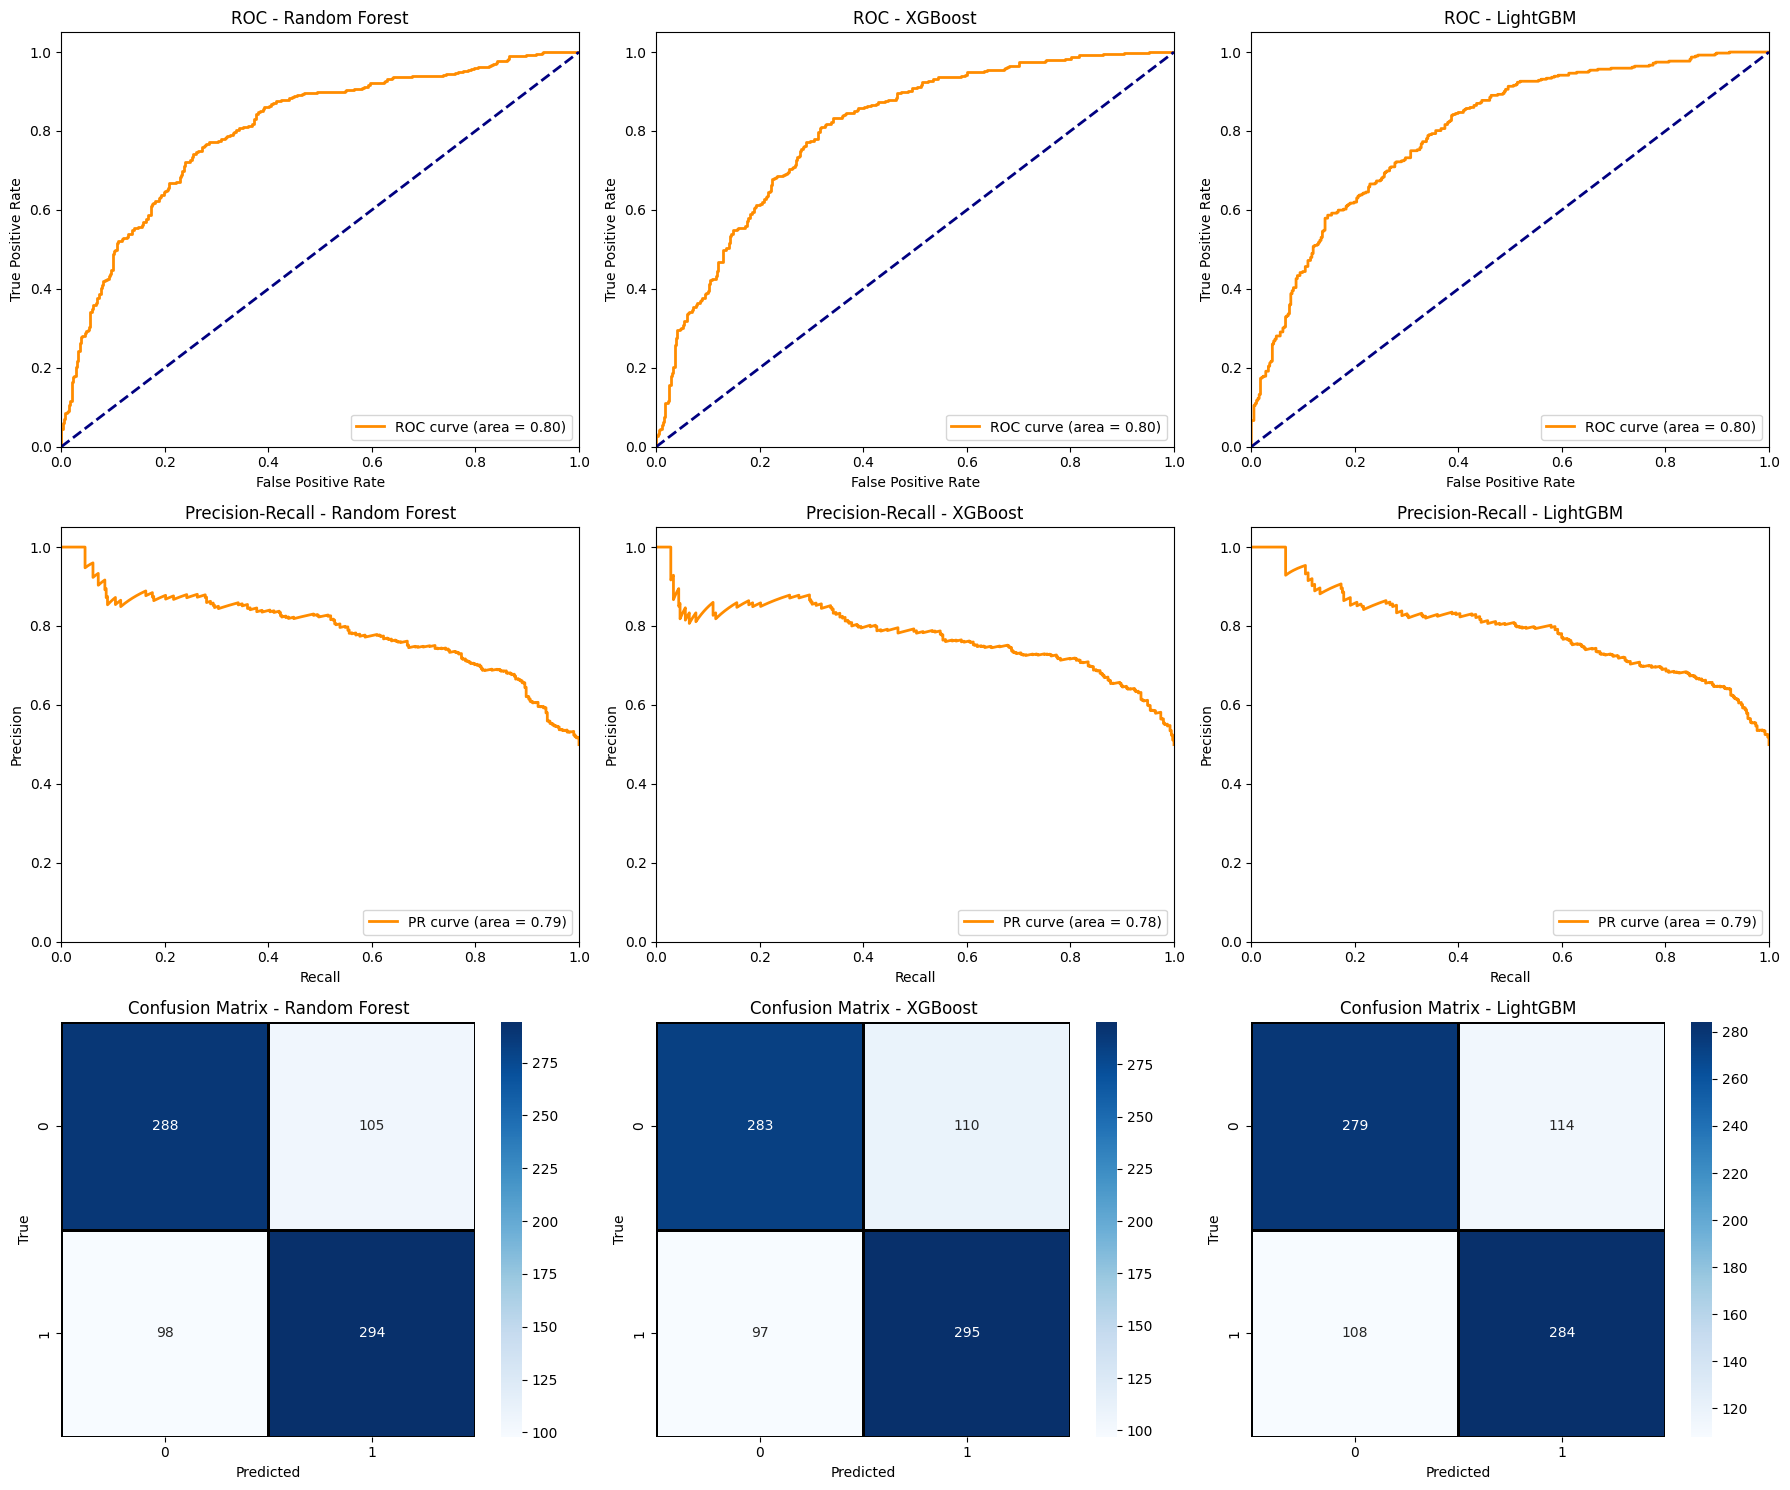

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.7414012738853503, 'Precision': 0.7368421052631579, 'Recall': 0.75, 'F1 Score': 0.743362831858407, 'ROC AUC': 0.8015981201640963}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.7363057324840764, 'Precision': 0.7283950617283951, 'Recall': 0.7525510204081632, 'F1 Score': 0.740276035131744, 'ROC AUC': 0.8034610790881238}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.7171974522292993, 'Precision': 0.7135678391959799, 'Recall': 0.7244897959183674, 'F1 Score': 0.718987341772152, 'ROC AUC': 0.7996929687905695}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.7171974522292993,
 'Precision': 0.7135678391959799,
 'Recall': 0.7244897959183674,
 'F1 Score': 0.718987341772152,
 'ROC AUC': 0.7996929687905695}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.7414


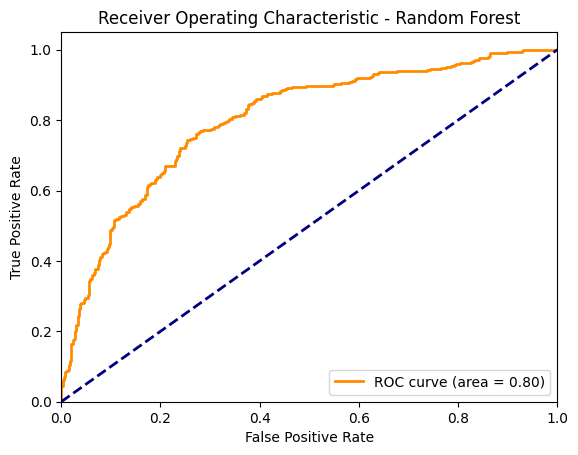

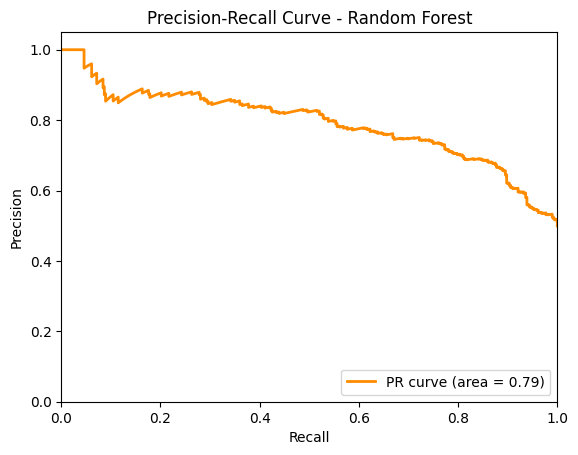

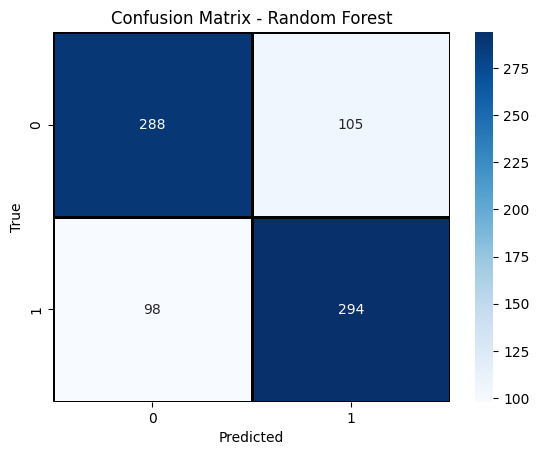

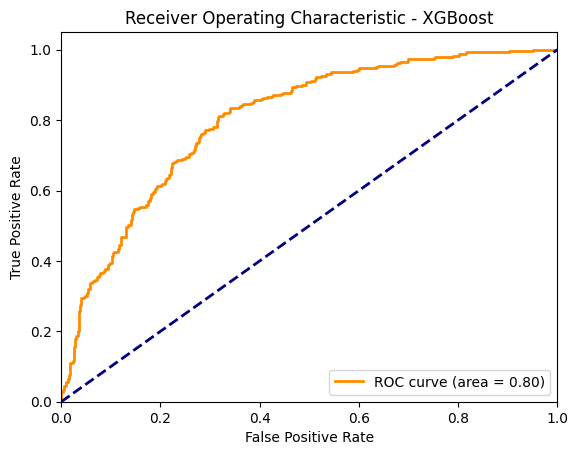

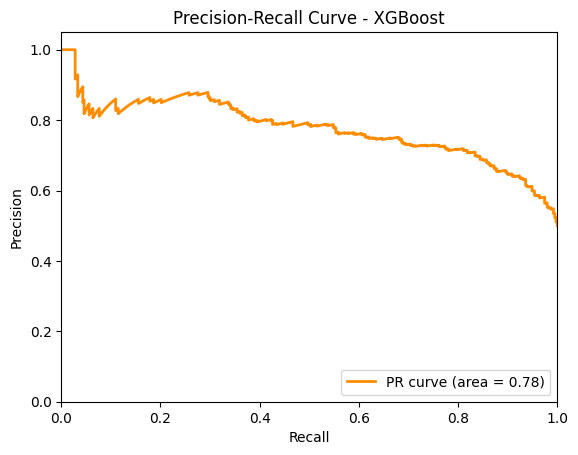

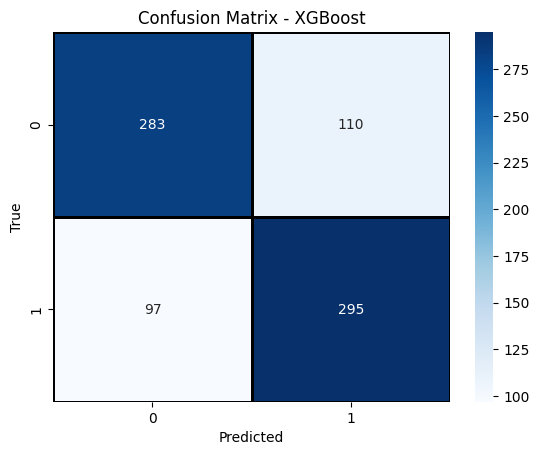

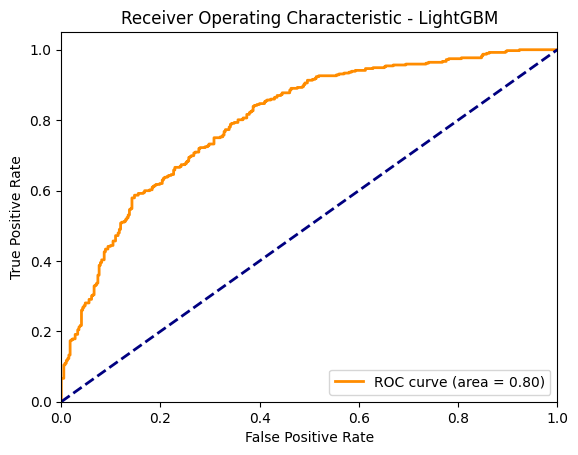

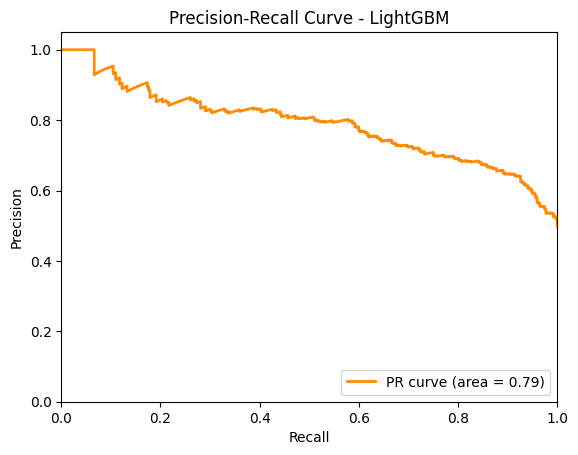

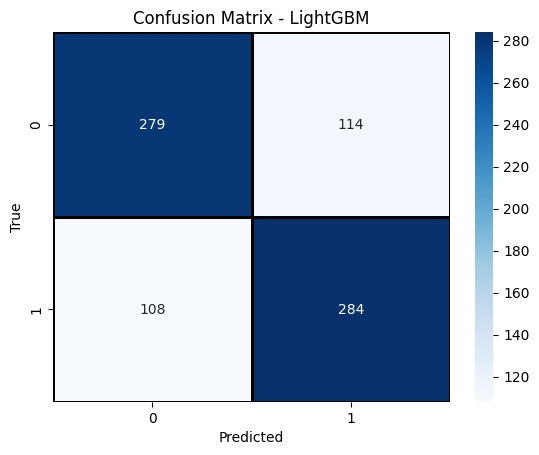

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

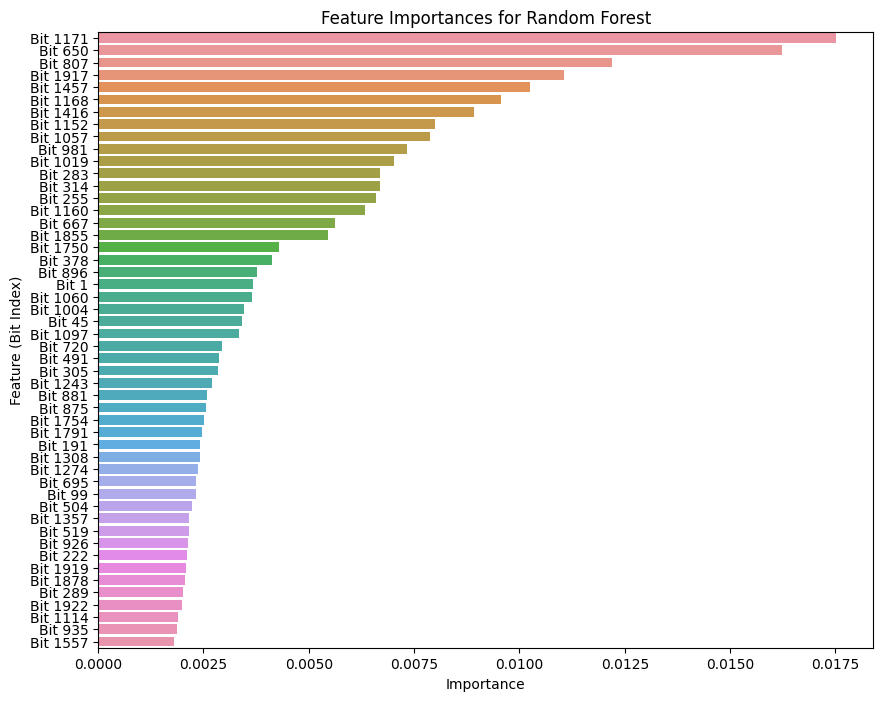

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
